In [1]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [6]:
VEF_df = pd.read_csv('../data/Becker_promoter/Becker_promoter_VEF_zscoreonGosai.tsv', sep='\t')
seq_df = pd.read_csv('../data/Becker_promoter/Becker_promoter_long.tsv', sep='\t')
seq_df

Promoter name                                        Description               Supposed specificity Origin (viral/mammalian/synthetic/chimeric)                                                seq  Total size of promoter (bp) Reference (PubMed ID) Size of LacZ stuffer (bp)  Final size of the construct
0            AAT  Promoter of Homo sapiens serpin family A membe...                              liver                                   mammalian  gatcttgctaccagtggaacagccactaaggattctgcagtgagag...                          397              10933977                      2000                         3923
1      AAT short                     Short version of hAAT promoter                              liver                                   mammalian  aatgactcctttcggtaagtgcagtggaagctgtacactgcccagg...                          251              10933977                      2200                         3977
2         ADIPOQ  Human Adiponectin, C1Q and collagen domain con...                                fat                                   mammalian  gcccttcaaaaacaaaacatgagcgtgccaagaaagtccaaggtgt...                         1077    15850785; 18931025                      1500                         4103
3        Albumin  Mus musculus albumin (Alb) 5' regulatory regio...                              liver                                   mammalian  ggcatgcttccatgccaaggcccacactgaaatgctcaaatgggag...                          335               2722822                      2200                         4061
4          AP2.2  Promoter region of Mus musculus adiponectin (r...                                fat                                   mammalian  aaaccacccagcaaaaaaccaaaccgcctagcctcaagacatgtgt...                         2274    18760339; 25551639                   no LacZ                         3800
..           ...                                                ...                                ...                                         ...                                                ...                          ...                   ...                       ...                          ...
53           TnT  Promoter of Homo sapiens troponin T2, cardiac ...                              heart                                   mammalian  ctcagtccattaggagccagtagcctggaagatgtctttaccccca...                          544              25082846                      2000                         4070
54           TTR  Enhancer + promoter region of Mus musculus tra...                              liver                                   mammalian  ggatctgtcaattcacgcgagttaataattaccagcgcgggccaaa...                          541               1690125                      2000                         4067
55           UBC  Promoter of Homo sapiens ubiquitin C (UBC) (re...                         ubiquitous                                   mammalian  ggtgcagcggcctccgcgccgggttttggcgcctcccgcgggcgcc...                         1258              11704814                      1200                         3984
56          UCP1  Mus musculus uncoupling protein 1 (Ucp) distal...  mitochondria/brown adipose tissue                                   mammalian  cgtcacagagggtcagtcacccttgaccacactgaactagtcgtca...                          527     28930673; 8264627                      2000                         4053
57           VEC  Promoter of Mus musculus cdh5 gene (ref. seq I...                  endothelial cells                                   mammalian  tcgtcgactctagctagtagcagaaacaaggtcctctggaagagca...                         2539     9864160; 30416049                   no LacZ                         4065

[58 rows x 9 columns]

In [3]:
cell_types = ['A549', 'AG04450_Fibroblast_Fetal_Lung', 'Astrocyte_Brain', 'BE2-C', 'BJ_Fibroblast_Foreskin', 'B_Lymphocyte_Blood', 'Brain', 'Caco-2_Epithelium_Colon', 'Embryonic_Stem_Cell_Embryo', 'Endothelial_Cell_Umbilical_Vein', 'Epithelium', 'Epithelium_Lung', 'Epithelium_Mammary_Gland', 'Fibroblast', 'GM06990_B_Lymphocyte_Blood', 'GM12878_B_Lymphocyte_Blood', 'GM12891_Lymphoblastoid_Blood', 'GM12892_Lymphoblastoid_Blood', 'GM18486_Lymphoblastoid_Blood', 'GM18505_Lymphoblastoid_Blood', 'GM19099_Lymphoblastoid_Blood', 'GM19193_Lymphoblastoid_Blood', 'GM19238_Lymphoblastoid_Blood', 'GM19239_Lymphoblastoid_Blood', 'GM19240_Lymphoblastoid_Blood', 'H1-hESC', 'H1_Embryonic_Stem_Cell_Embryo', 'HCT-116_Colorectal_cancer_cell_line', 'HL-60_Leukemia_Cell', 'HMEC_Mammary_Epithelial', 'HSMM_Skeletal_Muscle_Myoblasts', 'HSMMtube_Skeletal_Muscle_Myotubes_Derived_from_HSMM', 'HUVEC_Umbilical_Vein_Endothelial_Cells', 'HeLa-S3_Epithelium_Cervix', 'HeLa_Cervical_Carcinoma', 'HepG2_Hepatocellular_Carcinoma', 'IMR90_Fibroblast_Lung', 'Jurkat_T_Lymphocyte_Blood', 'K562_Leukemia_Cell', 'LNCaP_Epithelium_Prostate', 'LoVo_Colon', 'MCF-10A_Epithelium_Breast', 'MCF-7_Epithelium_Mammary_Gland', 'Macrophage_Blood', 'Monocyte_Blood', 'Myoblast_Muscle', 'NHDF-Ad_Fibroblast_Skin', 'NHEK_Epidermal_Keratinocytes', 'NHLF_Lung_Fibroblasts', 'NH_A_Astrocytes', 'Neuron', 'Osteoblast_Bone', 'PANC-1_Pancreatic_ductal', 'Pancreas', 'PrEC_Epithelium_Prostate', 'Retina', 'Rh4_rhabdomyosarcoma', 'Sigmoid_Colon', 'Stomach', 'T47D', 'T_Lymphocyte_Blood']
pred_cols = [f'{c}_pred' for c in cell_types]

assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [4]:
from joblib import dump, load
model = load("Gosai_MPRA_Sei_VEF_MLP.joblib")

In [5]:
all_columns = [f"{ct}_{assay}" for ct in cell_types for assay in assays]

# 把 (samples × (cell_types × assays)) 取出来
X_full = VEF_df[all_columns].to_numpy()

n_samples = VEF_df.shape[0]
n_cell_types = len(cell_types)
n_assays = len(assays)

# reshape 为 (samples * cell_types, assays)
X_flat = X_full.reshape(n_samples * n_cell_types, n_assays)

# ---- 预测 ----
y_pred_flat = model.predict(X_flat)

# ---- 折叠回去 ----
# 变成 (samples, cell_types)
y_pred = y_pred_flat.reshape(n_samples, n_cell_types)

print(y_pred.shape)
# np.save("Gosai_MPRA_Sei_VEF_MLP_pred_ct2.npy", y_pred)


(58, 61)


[25, 51, 45, 49, 46, 48, 2, 9, 29, 32, 56, 30, 31, 0, 52, 35, 7, 40, 11, 6, 55, 8, 50, 53, 58, 1, 13, 47, 10, 41, 28, 37, 3, 26, 34, 27, 33, 57, 39, 42, 59, 4, 36, 12, 54, 16, 17, 24, 22, 23, 21, 18, 19, 20, 5, 14, 15, 38, 60, 43, 44]


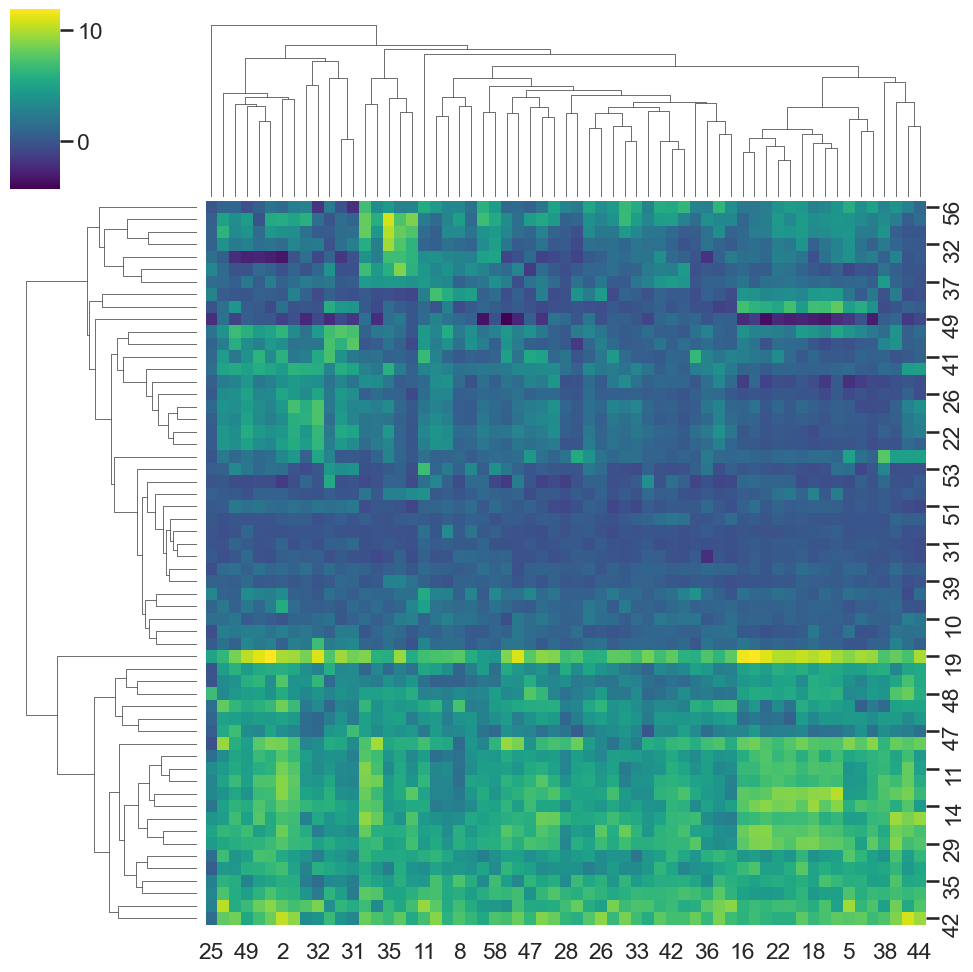

In [28]:
import seaborn as sns
import numpy as np

# y_pred: (N, 61) 矩阵
grid = sns.clustermap(y_pred, metric='euclidean', method='average',
                      cmap='viridis', figsize=(10, 10))

# 获取列（x 轴）的新顺序（0~60）
new_col_order = grid.dendrogram_col.reordered_ind
print(new_col_order)

In [48]:

seq_df['seq_name_specificity'] = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' : ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)

In [49]:
selected_sequences = ['CamKII', 'mAFP.Albumin', 'Des_mu', 'EF1α', 'CAG']
idx = [seq_df.index[seq_df['Promoter name'] == s][0] for s in selected_sequences]
print(idx)

[6, 33, 18, 19, 5]


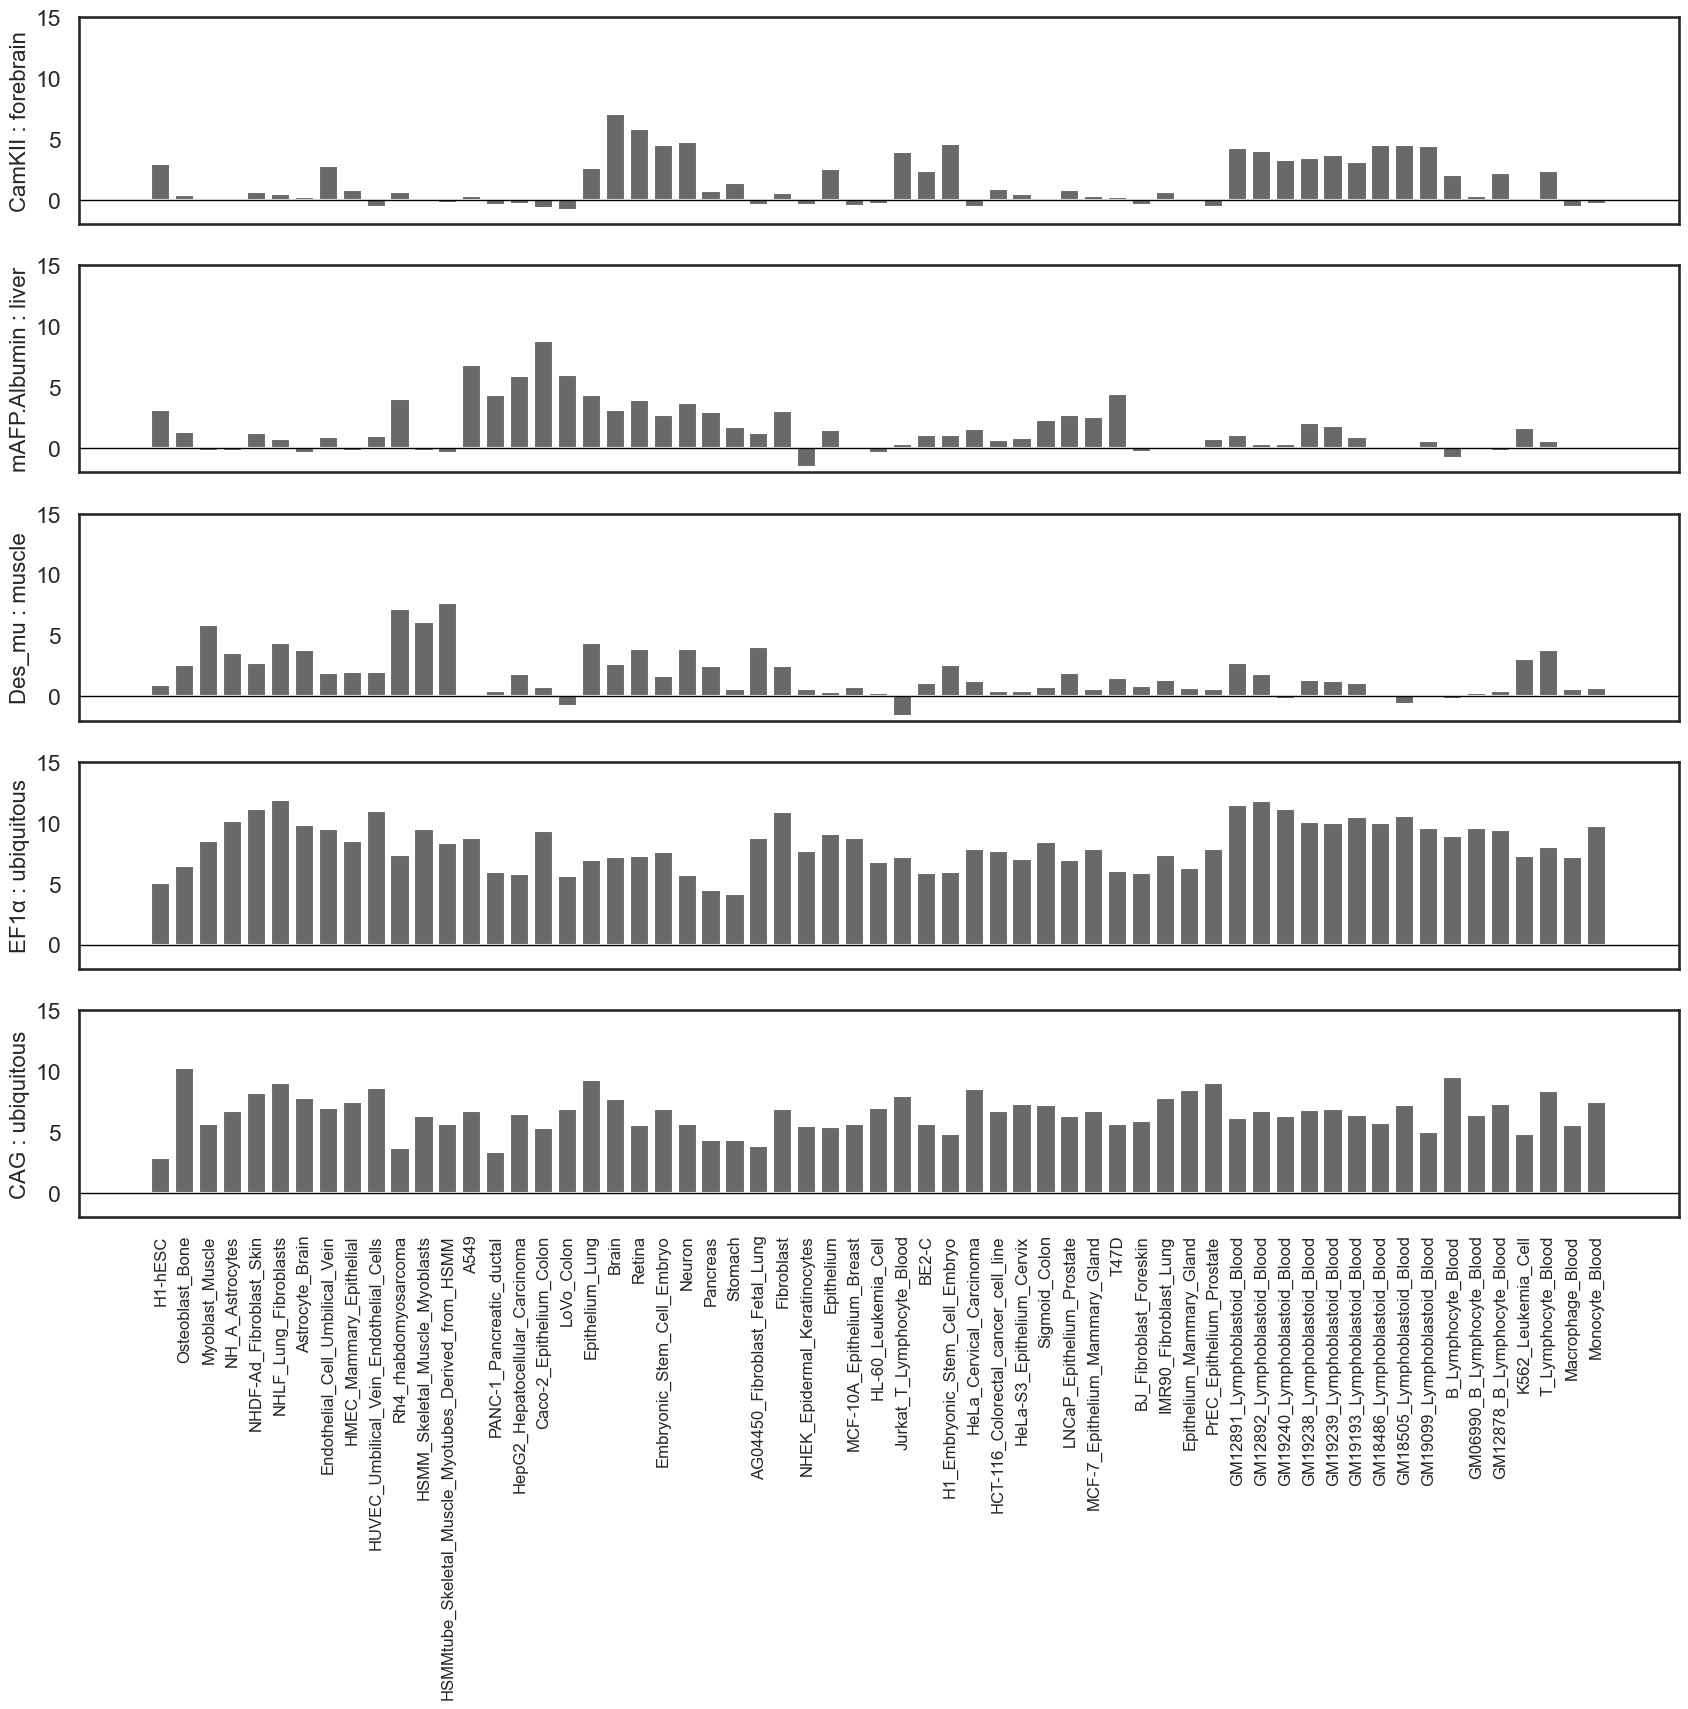

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# --- 根据聚类顺序重新排序列 ---
data = y_pred[idx][:, new_col_order]   # shape = (5, 61)

# --- 画图 ---
sns.set_theme(style="white", context="talk")
fig, axes = plt.subplots(5, 1, figsize=(20, 20), dpi=100, sharex=True)
plt.subplots_adjust(left=0.1, bottom=0.3, right=0.9, top=0.9)

for i in range(5):
    axes[i].bar(np.arange(data.shape[1]), data[i], color="dimgray")
    axes[i].set_ylabel(seq_df['seq_name_specificity'][idx[i]], fontsize=16)
    axes[i].axhline(0, color='black', linewidth=1)
    axes[i].set_ylim([-2, 15])

# x轴刻度对应新的顺序位置
axes[-1].set_xticks(np.arange(61))
axes[-1].set_xticklabels(np.array(cell_types)[new_col_order], rotation=90, fontsize=12)

plt.savefig('figures/gene_therapy_5_seq_61_cell_type_bar.png', dpi=400)
plt.savefig('figures_pdf/gene_therapy_5_seq_61_cell_type_bar.pdf', dpi=400)
plt.show()

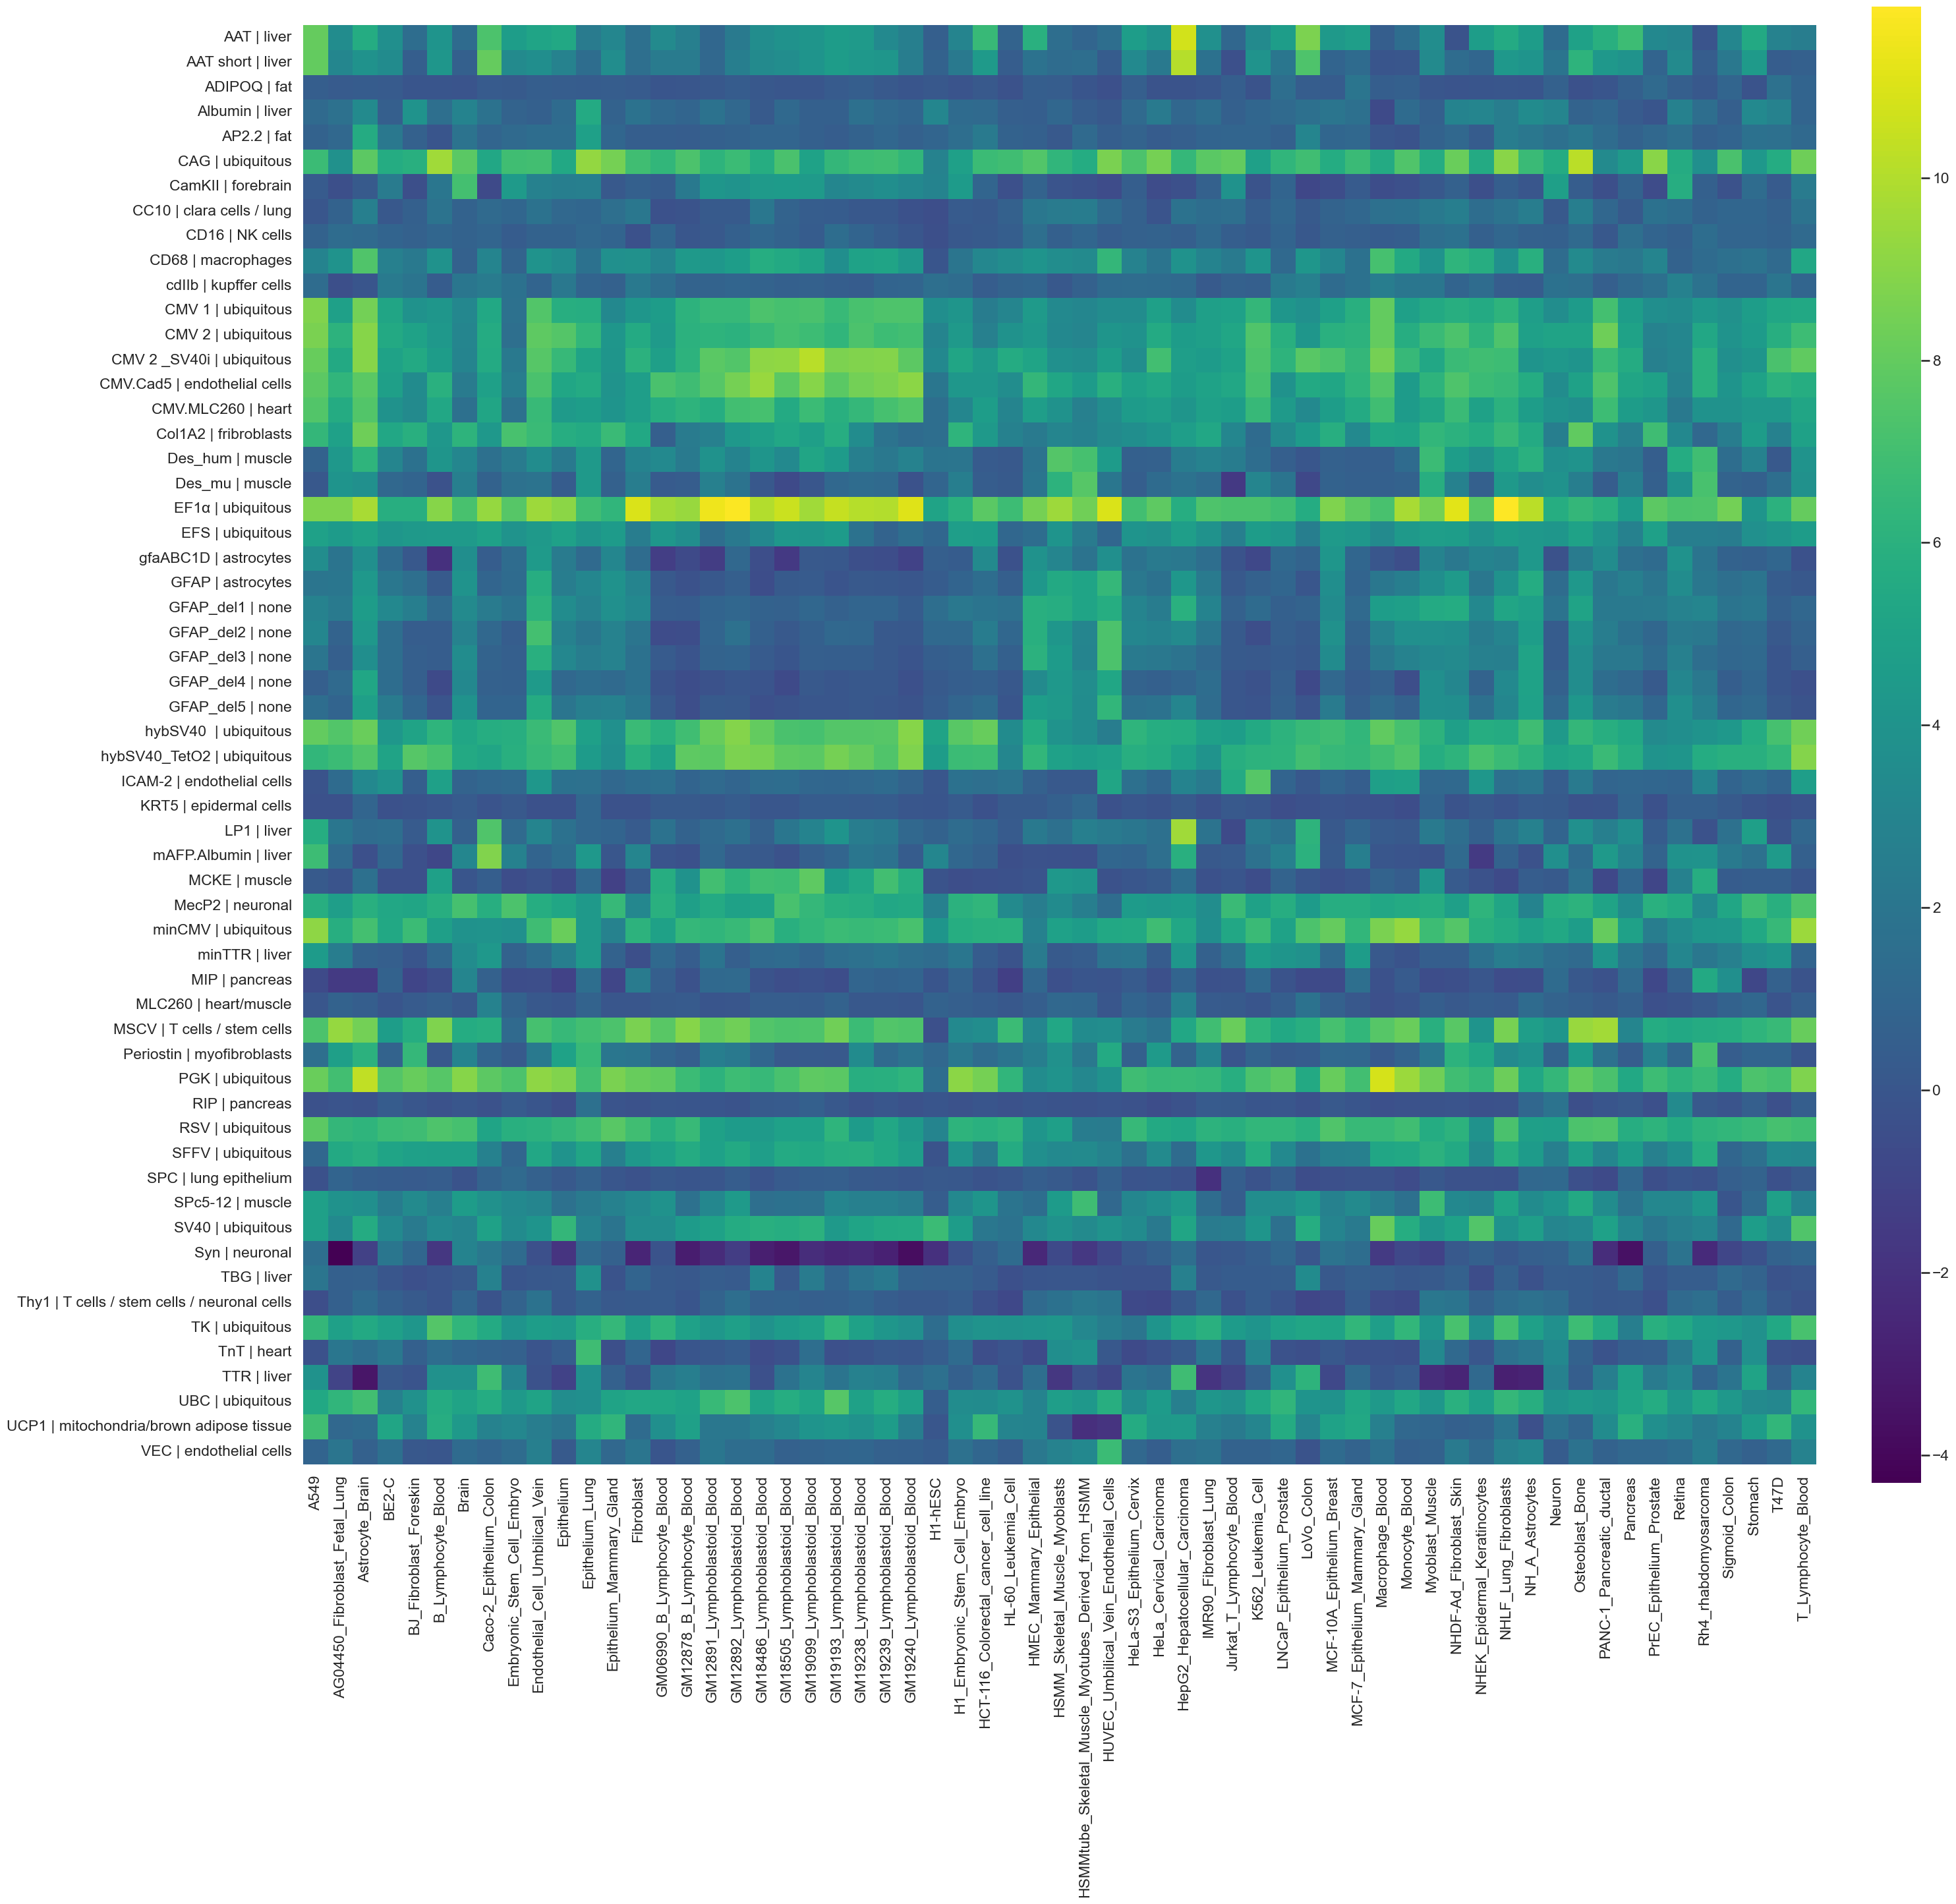

In [14]:
sns.set_theme(style="white", context="talk")  # 统一风格
fig, ax = plt.subplots(figsize=(40, 40), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

ax = sns.heatmap(
    y_pred,
    square=True,
    cmap='viridis',
    cbar_kws={
        'shrink': 0.8,   # 高度相对缩放（0~1）
        'aspect': 30,    # 宽高比，越大越瘦
        'pad': 0.03      # 与主图的距离
    }
)

xticklabels = cell_types
ax.set_xticklabels(xticklabels, rotation=90)

yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)
ax.set_yticklabels(yticklabels, rotation=0)

plt.savefig('figures/gene_therapy_EpiCast_VEF_only_prediction_heatmap.png', dpi=100)
plt.savefig('figures_pdf/gene_therapy_EpiCast_VEF_only_prediction_heatmap.pdf', dpi=400)
plt.show()

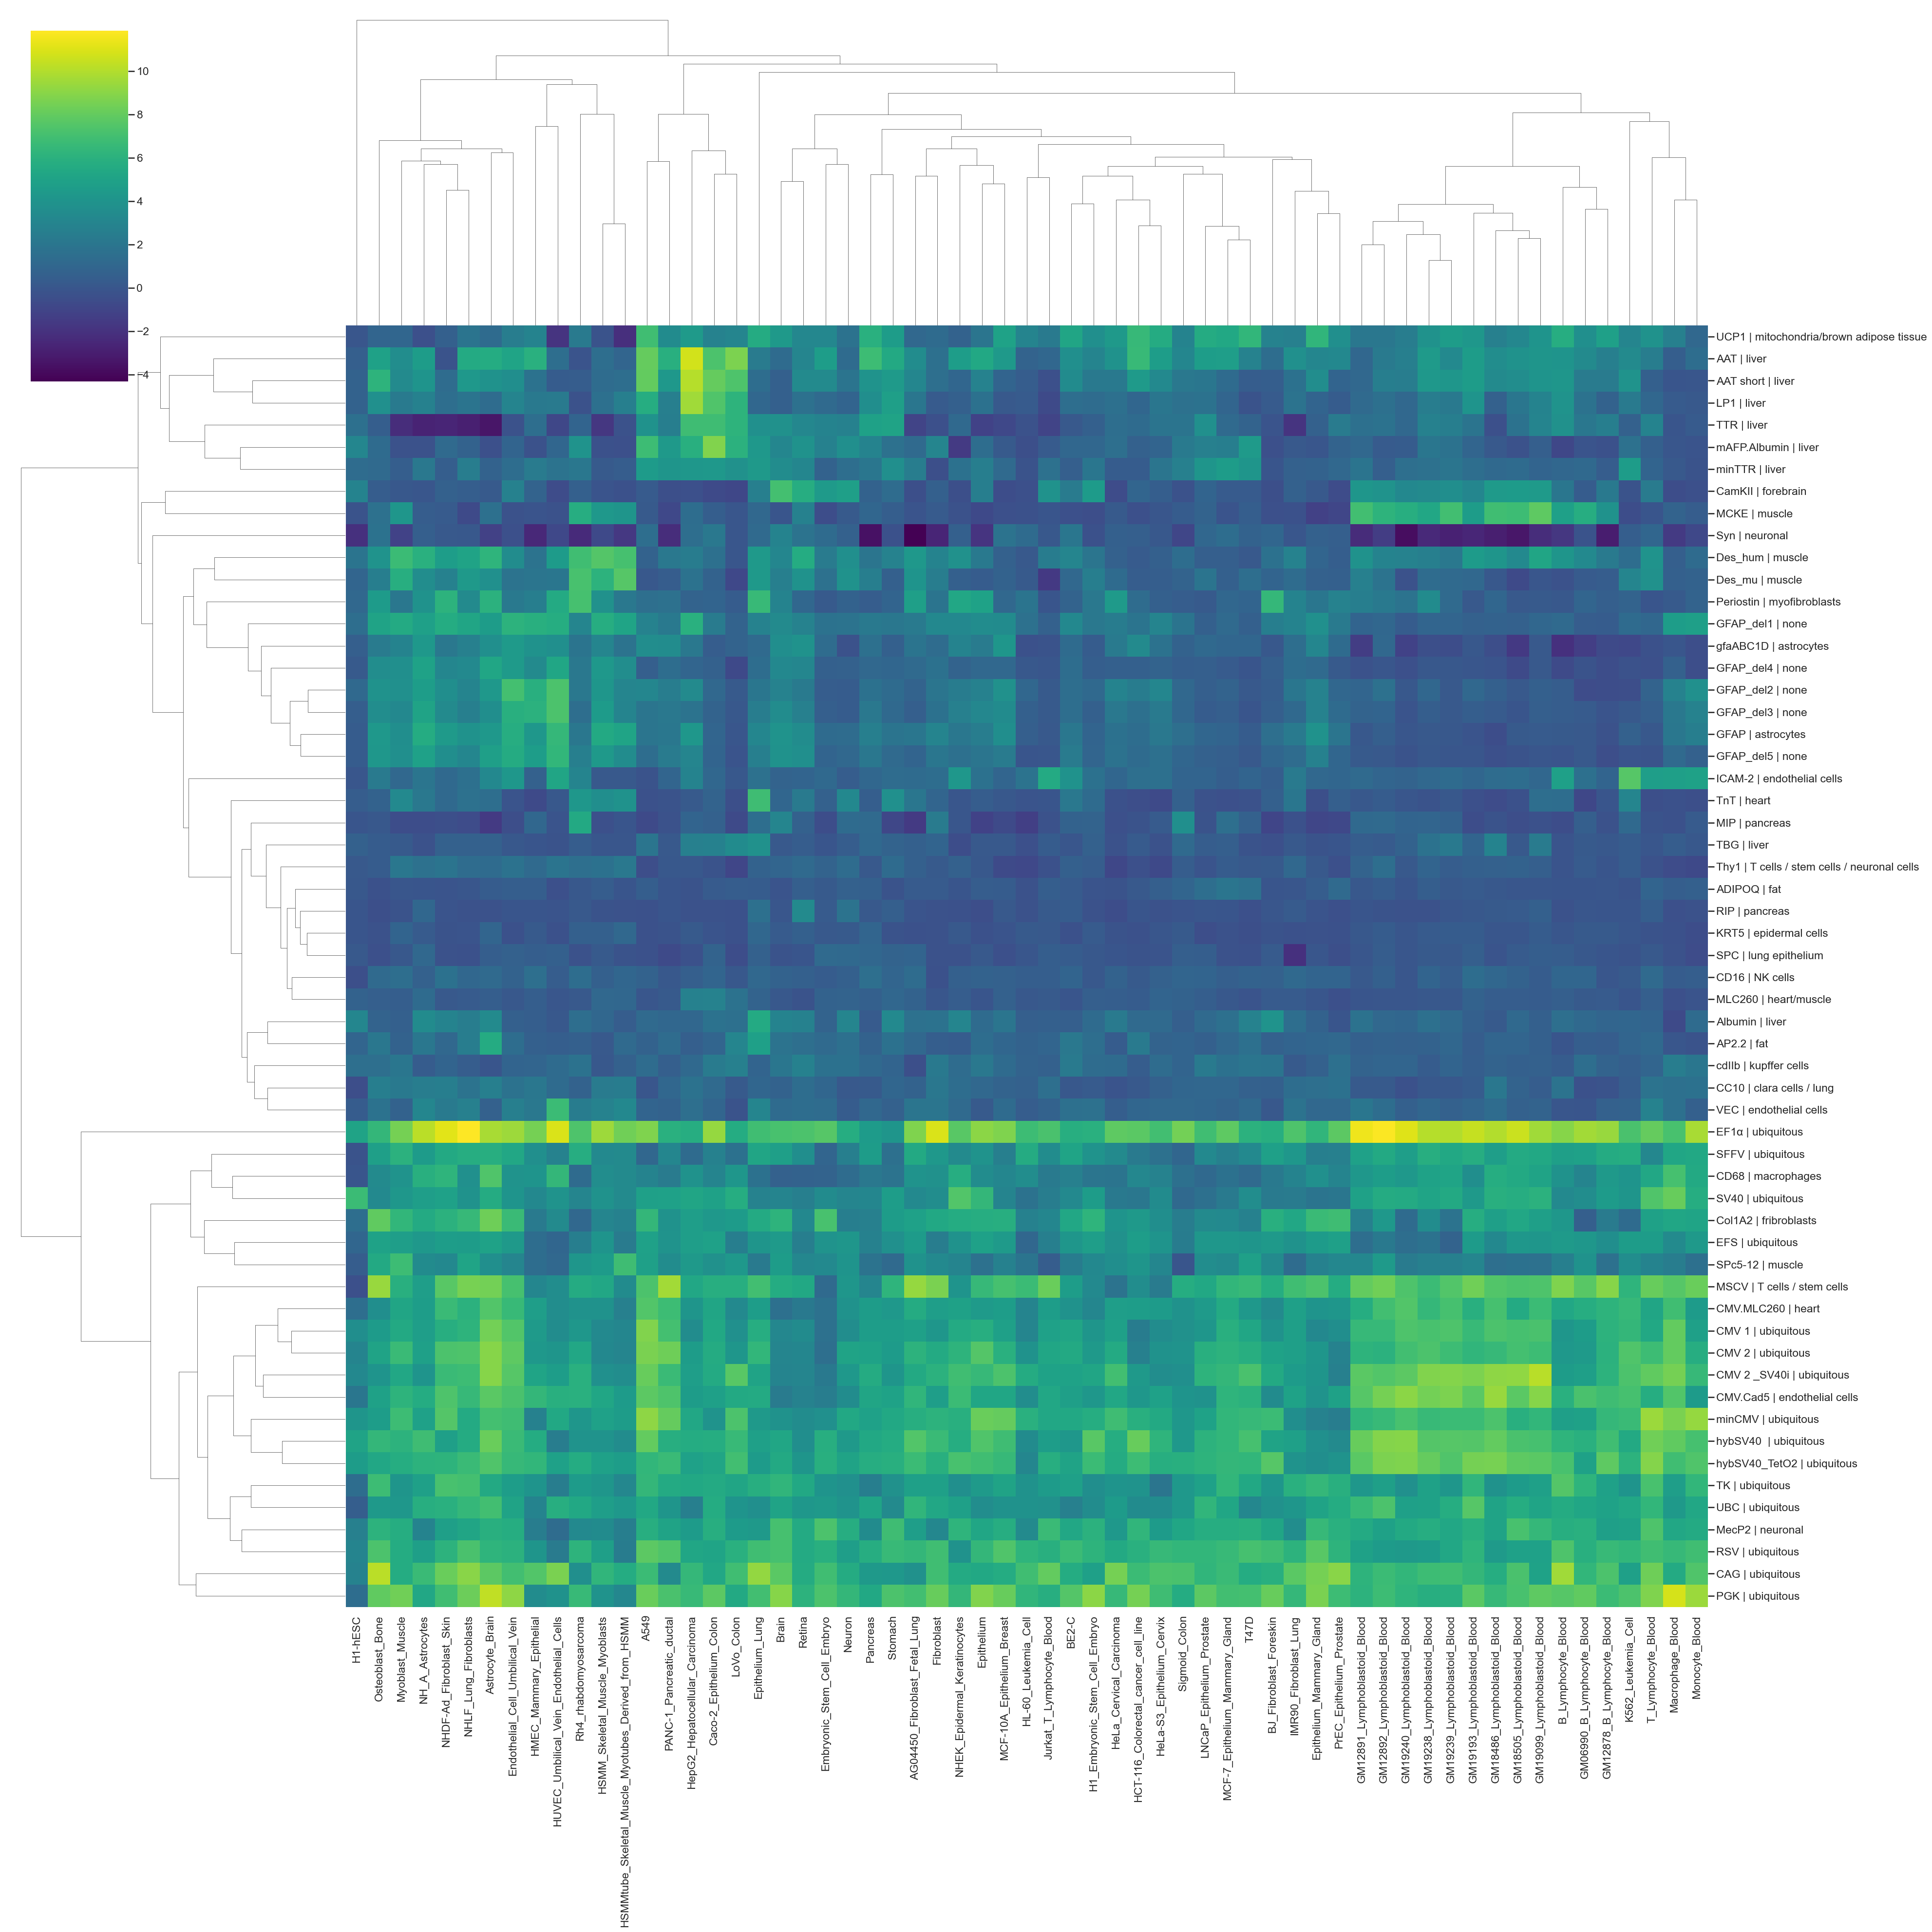

In [13]:
sns.set_theme(style="white", context="talk")
# fig, ax = plt.subplots(figsize=(40, 40), dpi=100)
# plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)


yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)
# clustermap 自动做双向聚类 + 树状图
g = sns.clustermap(
    y_pred,
    method="average",    # 聚类方式
    metric="euclidean",  # 距离方式
    cmap="viridis",
    figsize=(40, 40),
    row_cluster=True,
    col_cluster=True,
    xticklabels=cell_types,
    yticklabels=yticklabels,
    cbar_kws={
        'shrink': 0.8,
        'aspect': 30,
        'pad': 0.03
    },
)
plt.savefig('figures/gene_therapy_EpiCast_VEF_only_prediction_heatmap_cluster.png', dpi=100)
plt.savefig('figures_pdf/gene_therapy_EpiCast_VEF_only_prediction_heatmap_cluster.pdf', dpi=400)
plt.show()

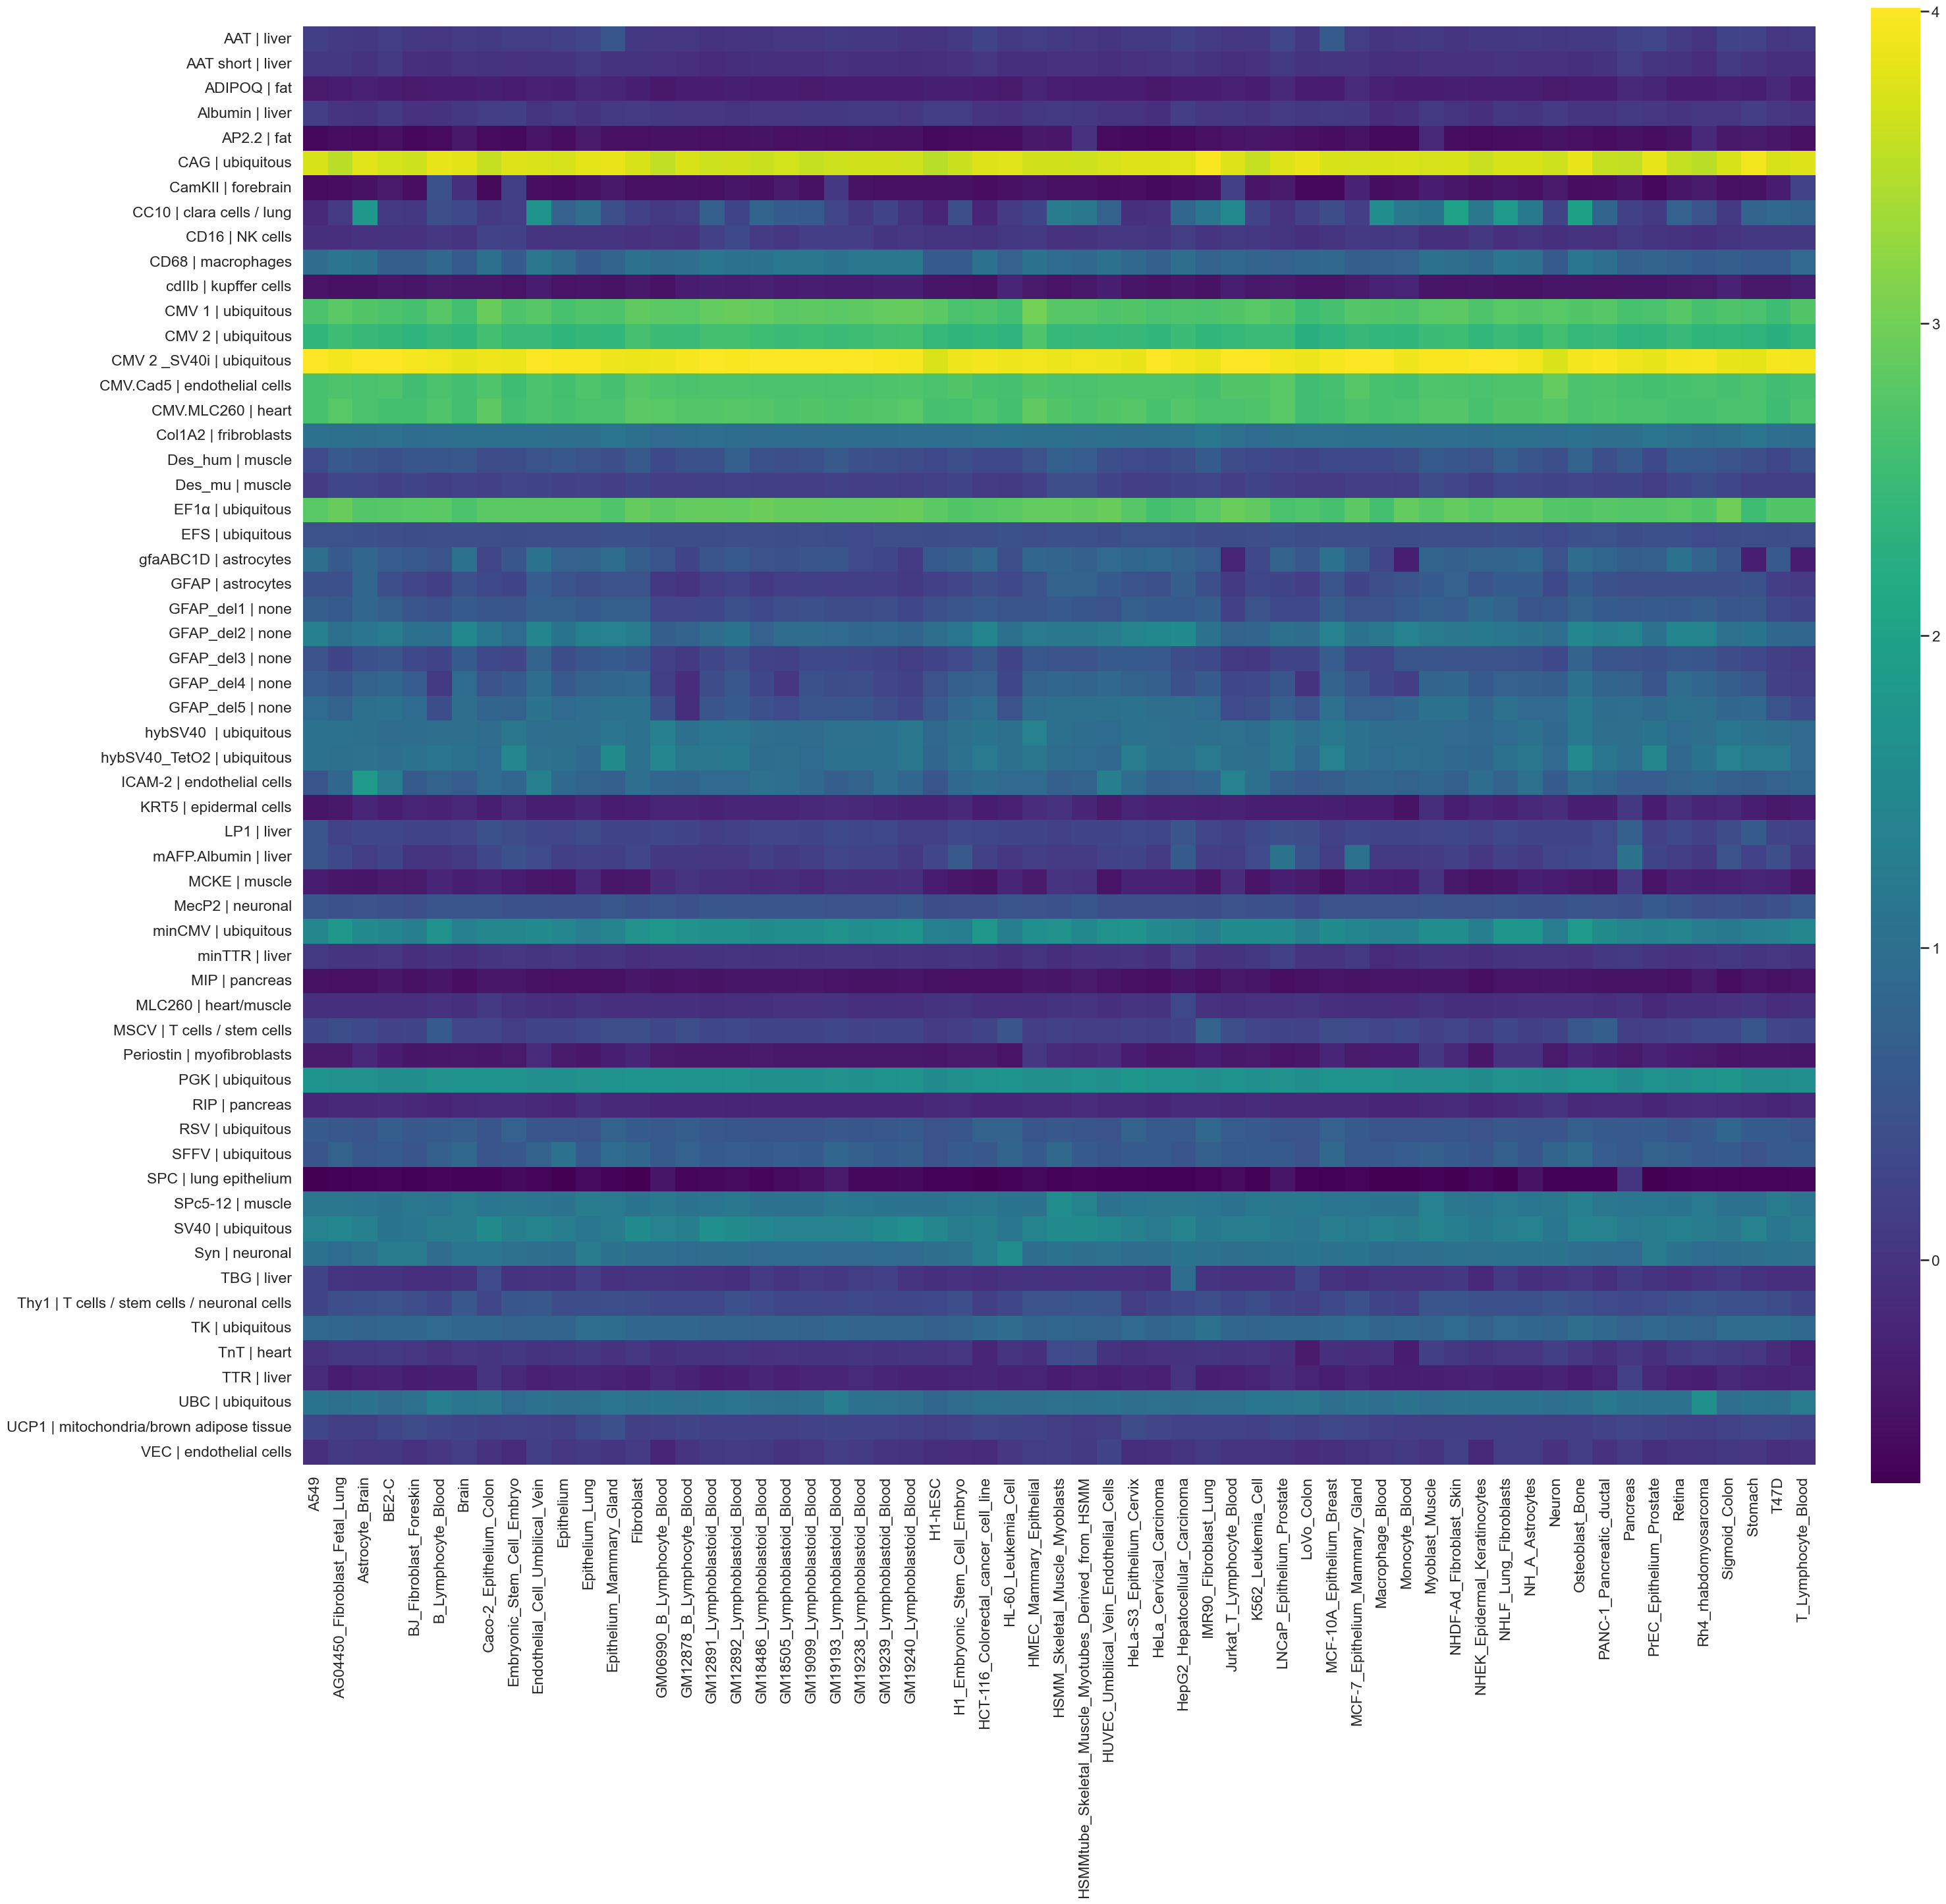

In [38]:
sns.set_theme(style="white", context="talk")  # 统一风格
fig, ax = plt.subplots(figsize=(40, 40), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

ax = sns.heatmap(
    y_pred,
    square=True,
    cmap='viridis',
    cbar_kws={
        'shrink': 0.8,   # 高度相对缩放（0~1）
        'aspect': 30,    # 宽高比，越大越瘦
        'pad': 0.03      # 与主图的距离
    }
)

xticklabels = cell_types
ax.set_xticks(np.arange(len(xticklabels)) + 0.5)
ax.set_xticklabels(xticklabels, rotation=90)


yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)
ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
ax.set_yticklabels(yticklabels, rotation=0)

plt.savefig('figures/gene_therapy_prediction_heatmap.png', dpi=100)
plt.show()

In [39]:
# 每条序列 内部归一化
pred = (pred - pred.mean(axis=1, keepdims=True)) / pred.std(axis=1, keepdims=True)

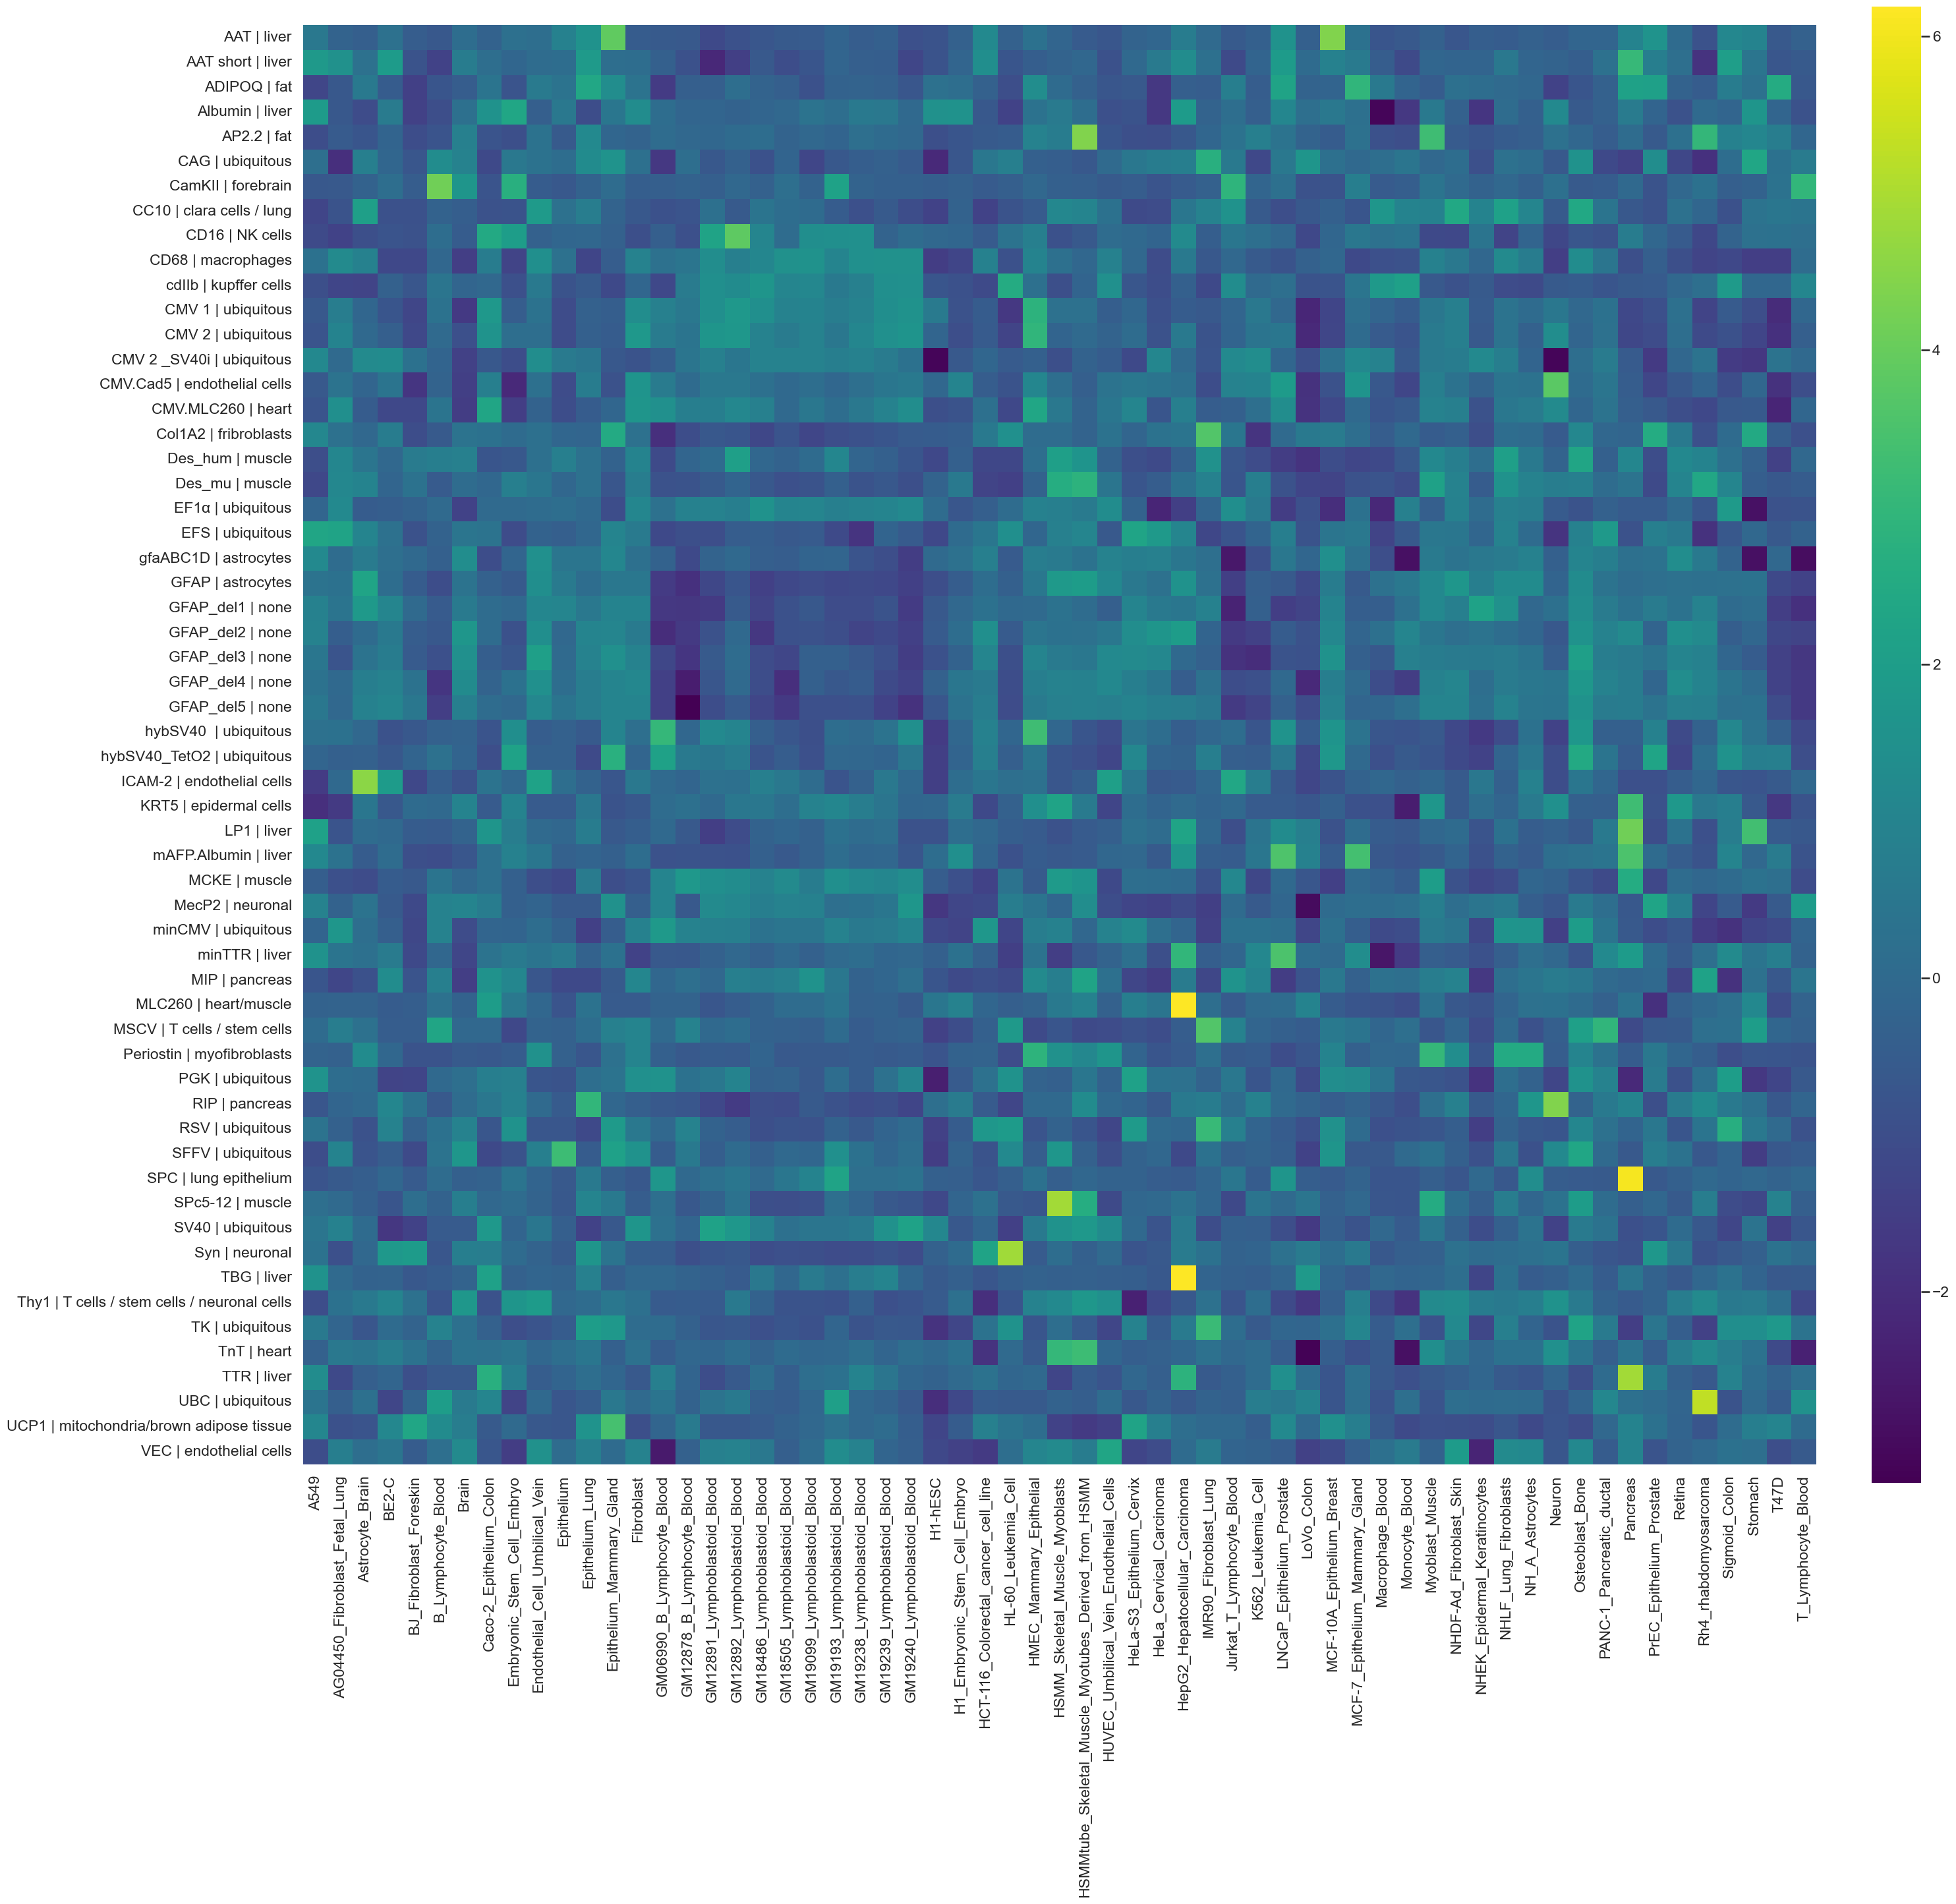

In [40]:
sns.set_theme(style="white", context="talk")  # 统一风格
fig, ax = plt.subplots(figsize=(40, 40), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

ax = sns.heatmap(
    pred,
    square=True,
    cmap='viridis',
    cbar_kws={
        'shrink': 0.8,   # 高度相对缩放（0~1）
        'aspect': 30,    # 宽高比，越大越瘦
        'pad': 0.03      # 与主图的距离
    }
)

xticklabels = cell_types
ax.set_xticks(np.arange(len(xticklabels)) + 0.5)
ax.set_xticklabels(xticklabels, rotation=90)


yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)
ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
ax.set_yticklabels(yticklabels, rotation=0)

plt.savefig('figures/gene_therapy_prediction_heatmap.png', dpi=100)
plt.show()

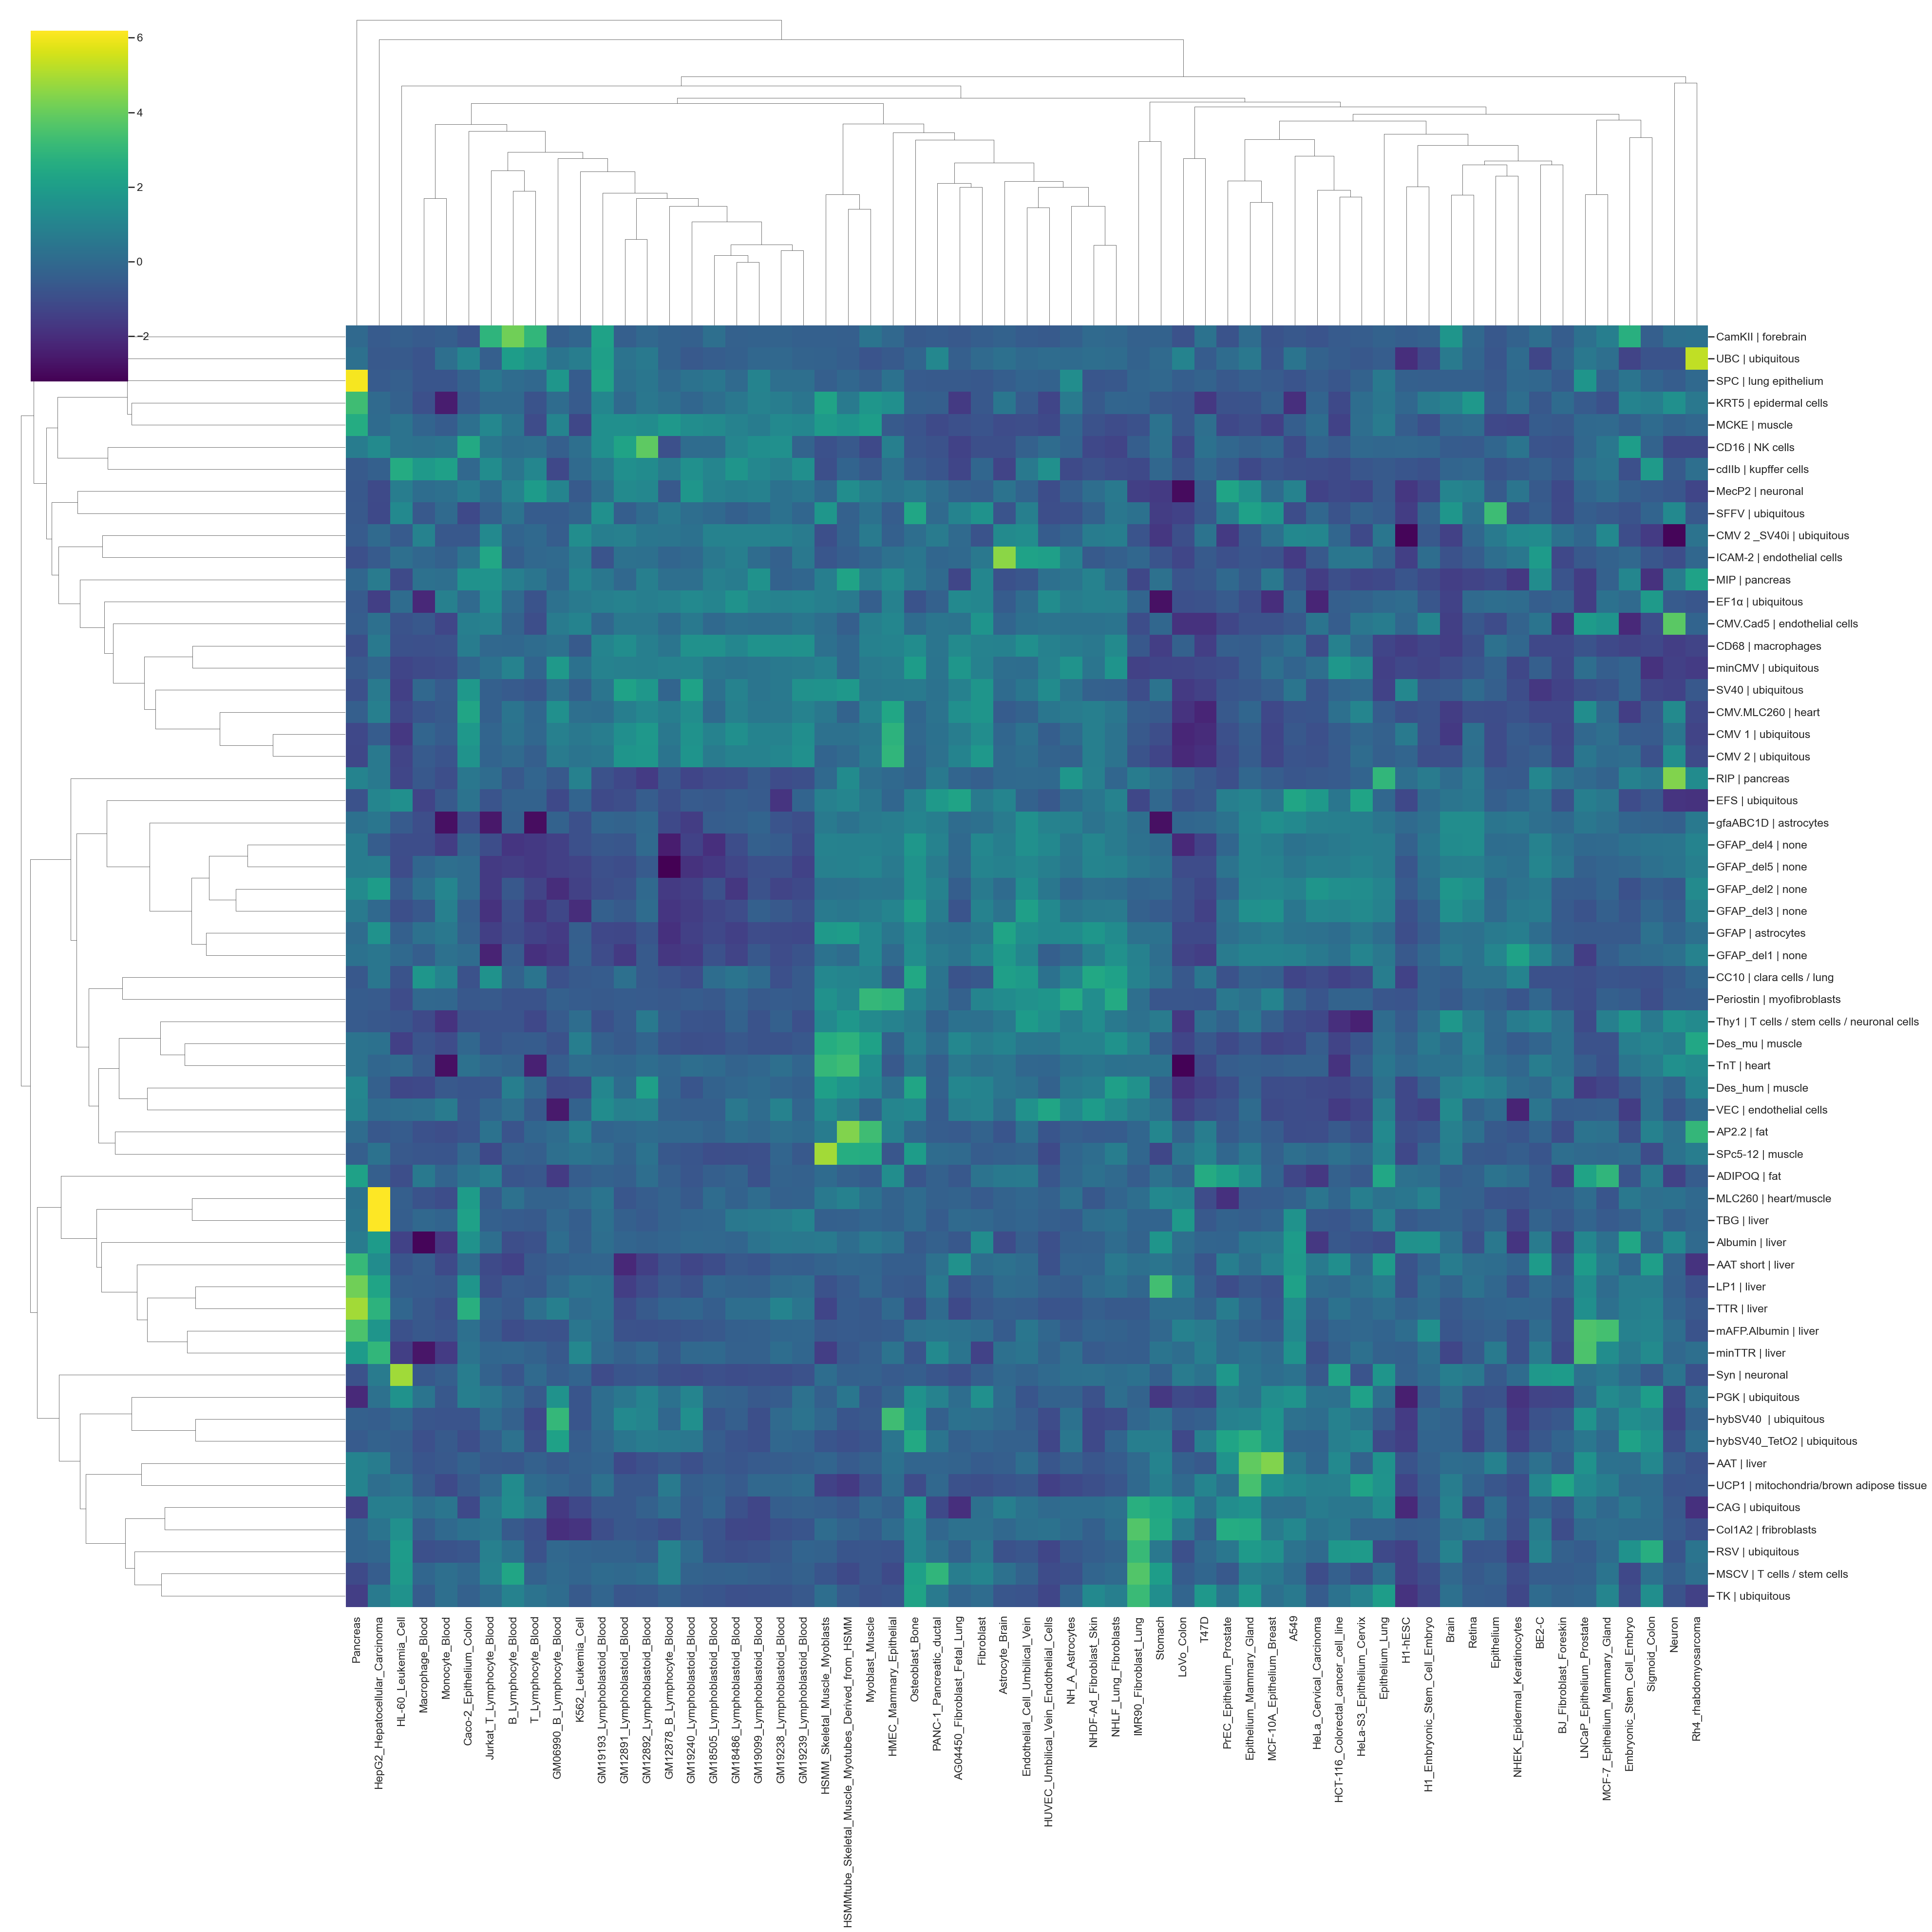

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 构建行名
yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)

# clustermap 自动做双向聚类 + 树状图
g = sns.clustermap(
    pred,
    method="average",    # 聚类方式
    metric="euclidean",  # 距离方式
    cmap="viridis",
    figsize=(40, 40),
    row_cluster=True,
    col_cluster=True,
    xticklabels=cell_types,
    yticklabels=yticklabels,
    cbar_kws={
        'shrink': 0.8,
        'aspect': 30,
        'pad': 0.03
    }
)

plt.savefig('figures/gene_therapy_prediction_clustermap.png', dpi=100)
plt.show()


In [42]:
seq_df = pd.read_csv('../data/Becker_promoter/Becker_promoter_long.tsv', sep='\t')
VEF_df = pd.read_csv('../data/Becker_promoter/Becker_promoter_VEF.tsv', sep='\t')


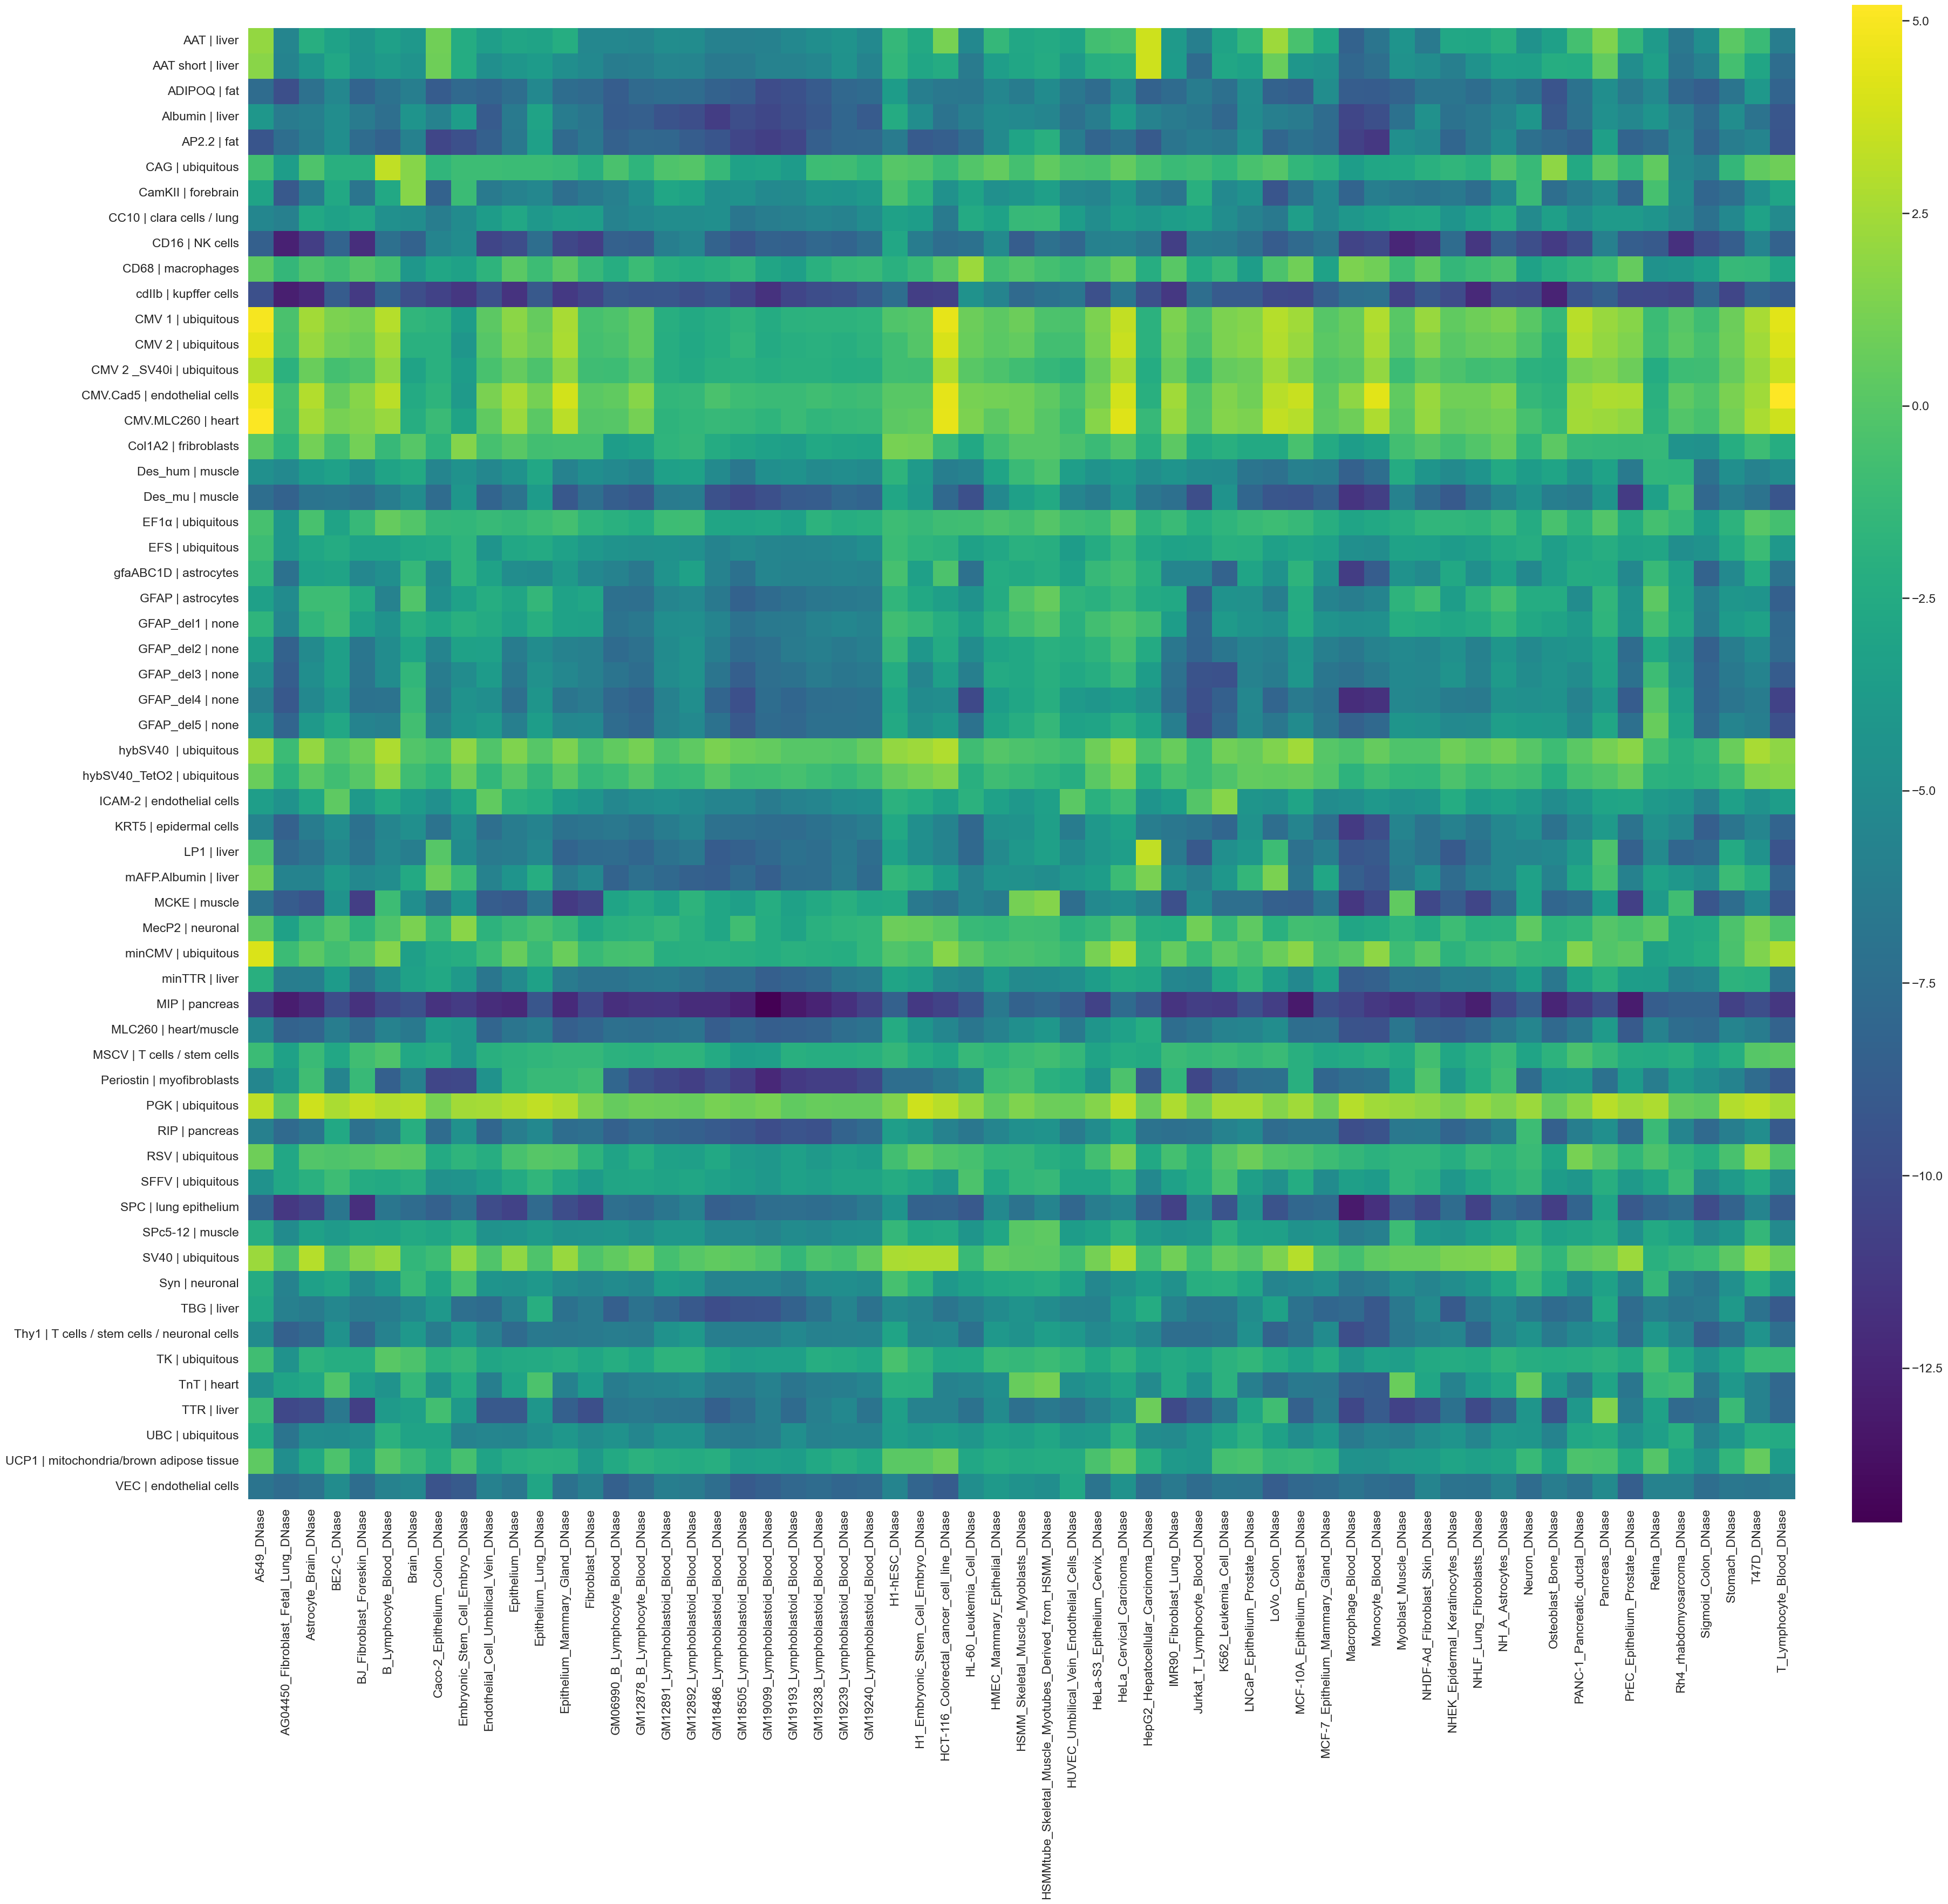

In [43]:
DNase_cols = [c for c in VEF_df.columns if c.endswith('_DNase')]


sns.set_theme(style="white", context="talk")  # 统一风格
fig, ax = plt.subplots(figsize=(40, 40), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)


ax = sns.heatmap(
    VEF_df[DNase_cols],
    square=True,
    cmap='viridis',
    cbar_kws={
        'shrink': 0.8,   # 高度相对缩放（0~1）
        'aspect': 30,    # 宽高比，越大越瘦
        'pad': 0.03      # 与主图的距离
    }
)

yticklabels = (
    seq_df['Promoter name'].fillna('none').astype(str)
    + ' | ' +
    seq_df['Supposed specificity'].fillna('none').astype(str)
)

# ytick 偏移 0.5 以与方块中心对齐
ax.set_yticks(np.arange(len(yticklabels)) + 0.5)
ax.set_yticklabels(yticklabels, rotation=0)

plt.tight_layout()
plt.savefig('figures/gene_therapy_DNase.png', dpi=100)
plt.show()